In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import random
import seaborn as sns
from wordfreq import word_frequency as wf 

# FILE IMPORTS

In [2]:
Word_Bank_File_Name = 'words.csv'
Historical_File_Name = 'historical.txt'

In [3]:
#12000 word file stored as words_12k
words_12k=pd.read_csv('data/'+Word_Bank_File_Name)['words'].str.upper()

words_refine=open('data/words_refine.txt','r').read().split('\n')



#Historical Words stored as words_historicals
historicals_txt=open('data/'+Historical_File_Name,'r').readlines()[0]
words_historicals=pd.DataFrame(historicals_txt.split(" "),columns=['words'])['words'].str.upper()



# CRITICAL DEFS

In [4]:
def unique(list1):
  
    
    unique_list = []
  
    
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
    


def getCharDistribution(word_list):
    Chars_List={}
    for word in words['words']:
        chars=unique([*word])
        for c in chars:
            if c not in Chars_List:
                Chars_List[c]=0
            Chars_List[c]+=1
    Sorted_Chars=dict(sorted(Chars_List.items(),key=lambda x:x[1],reverse=True))
    
    return Sorted_Chars
    

def getMaxFreq(word_corpus):
    
    Old=wf(word_corpus[0],'en')
    Word_Track=word_corpus[0]
    
    for word in word_corpus:
        New=max(wf(word,'en'),Old)
        if(New>Old):
            Word_Track=word
        
        Old=New
        
    return Word_Track



In [307]:
def sortDict(Dict):
    '''THis method sorts a dictionary by the descending order of
        its values'''
    
    Ret_Dict = {key: Dict[key] for key in sorted(Dict.keys(), key=Dict.__getitem__,reverse=True)}
    
    return Ret_Dict

        
    
    

# WORDLE SIM

In [5]:
class WordleSim:
    
    ##Initializes the state 2D array, with [guess letter, state]
    ## 0: Not in Word
    ## 1: Yellow
    ## 2: Green
    ## 
    
    def __init__(self,word):
        self.source_word=word.upper()
        self.num_tries=0
        self.Game_State=[[]]
        self.win=False
        
        for i in range(0,4):
            self.Game_State.append(["",-1])
        

    def __str__(self, word):
        self.source_word=word.upper()
        self.num_tries=0
        
    def play(self,guess):
        Char_List=[*guess.upper()]
        
        for i in range(0,len(Char_List)):
            state_var=0
            if Char_List[i]==[*self.source_word][i]:
                state_var=2
                
            elif Char_List[i] in [*self.source_word]:
                state_var=1
            
            self.Game_State[i]=[Char_List[i],state_var]
            
        self.num_tries+=1
        
        #################
        
        if self.source_word==guess:
            self.win=True
            
            
        return self.Game_State, self.num_tries, self.win
        
    def getTries(self):
        return self.num_tries
    

# EXPERT (V6) Solver

In [309]:
class exp_WordleSolver:



    def __init__(self, file_loc="data/words_refine.txt"):
        
        with open(file_loc,'r') as f:
            word_list = f.read().upper().split('\n')
        
        word_list.sort()
        self.word_list = word_list
        self.original_list=word_list
        self.correct_chars=[]
        self.notTieBreak=True
        
        self.randomizer="111000000000"
    
    
        #TieBreakVars
        self.used_chars=[]
        self.correct_chars=[]
        self.guesses=0
    
    
    
    
    def measure_distribution(self):
        dist_list = [{},{},{},{},{}]
        for i,word in enumerate(self.word_list):
            for j,letter in enumerate(word):
                dict = dist_list[j]
                if letter in dict:
                    dict[letter] = dict[letter]+1
                else:
                    dict[letter] = 1

        return dist_list
    
    def measure_frequency(self):
        letters = "".join(self.word_list)
        dict_freq = {}

        for i in range(60,91):
            dict_freq[chr(i)] = 0

        for i in letters:
            dict_freq[i] = dict_freq[i] + 1

        return dict_freq

    def generate_random(self):
        return random.choice(self.word_list)
    
    def generate_frequency(self):

        #Generates a word based on frequency ranker
        guess_word = ""
        max_score = 0
        dist_list = self.measure_frequency()

        for word in self.word_list:
            score = 0
            for j,letter in enumerate(word):
                score = score + dist_list[letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word

    def generate_frequency_wp(self):

        #Generates a word based on frequency ranker
        guess_word = ""
        max_score = 0
        dist_list = self.measure_frequency()

        for word in self.word_list:
            score = 0
            for j,letter in enumerate(word):
                if(letter not in word[:j]):
                    score = score + dist_list[letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word
    
    def generate_bucket(self):

        #Generates a word based on bucket ranker
        guess_word = ""
        max_score = 0
        dist_list = self.measure_distribution()

        for i,word in enumerate(self.word_list):
            score = 0
            for j,letter in enumerate(word):
                score = score + dist_list[j][letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word
    
    def generate_bucket_wp(self):

        #Generates a word based on bucket ranker with penalty
        guess_word = ""
        max_score = 0
        dist_list = self.measure_distribution()

        for i,word in enumerate(self.word_list):
            score = 0
            for j,letter in enumerate(word):
                if(letter not in word[:j]):
                    score = score + dist_list[j][letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word
    
################################################################

    def tieBreak(self):
        
        
        
        if(len(self.word_list)>2 and self.guesses>4):
            return ''
    
        
        #List of remaining letters
        Letters=self.getRemLetters()
        Letters,Ranks=self.rankRemLetters(Letters)
        
        
        #Now letters are sorted, lets get max score
        maxscore=0
        ret_word=''
        
        
        Word_Scores={}
        
            
            
            
        for word in self.original_list:
            score=0
            
            for L in Letters:
            
                if L in word:
                    
                    score+=1*Ranks[L]
            

            if score>2:
                Word_Scores[word]=score
                    
                
        Word_Scores=sortDict(Word_Scores)
        
        if(len(Word_Scores)>0):
            return list(Word_Scores.keys())[0]
        else:
            
            return ''
        
        
    def checkTie(self):
        
        guess_word = ""
        max_score = 0
        dist_list = self.measure_distribution()
        Score_Dict={}

        for i,word in enumerate(self.word_list):
            score = 0
            for j,letter in enumerate(word):
                score = score + dist_list[j][letter]
                
            
            Score_Dict[word]=score
        
        
        #print(np.std(list(Score_Dict.values())))
        if np.std(list(Score_Dict.values()))<=2 and len(Score_Dict)>0:
            
            return True
        
        else:
            return False
        
        

    def generate_mixed_wp(self):
        self.guesses+=1
        word1=self.generate_bucket_wp()
        word2=getMaxFreq(self.word_list)

        Path=self.randomizer[0]
        self.randomizer=self.randomizer[1:]
        
        
        
        
        if(Path=='1'):
            returner=word1
        else:
            returner=word2
        
        
        #TieBreak
        
        if(self.checkTie()==True):
            word3=self.tieBreak()
            
            #print(self.word_list)
            

            
            if(len(word3)>0):
                returner=word3
    
        
        
        
        
        
        #Update usechars
        
        for char in returner:
            
            if char in self.used_chars:
                x=0
                
            else:
                self.used_chars.append(char)
            
            
            

            
        return returner

    
    
    
    def rankRemLetters(self, Letters):
        
        Ranks={Letters[i]:0 for i in range(0,len(Letters))}
           
        
        for each in range(0,len(Letters)):
            
            for word in self.word_list:
                
                if(Letters[each] in word):
                    
                    Ranks[Letters[each]]+=1
        
        
        #Now to do a Descending Bubblesort on a dict
        
        Ranks=sortDict(Ranks)

        
                    
        return list(Ranks.keys()),Ranks
     
    
    
    
    def getRemLetters(self):
        
        #List of all chars, unprioritized
        
        RetList=[]
        
        
        for word in self.word_list:
            
            for char in word:
                
                occurences={}
                
                #Case 1: Double char but it has been guessed
                if char in self.correct_chars:
                    
                    #repeat checker
                    if char in occurences:
                        RetList.append(char)
                        
                    else:
                        occurences[char]=1
                
                elif (char in self.used_chars)==False:
                    
                    if (char in RetList)==False:
                        
                        RetList.append(char)  

        

        return RetList
                    




    def update(self, info=[]):
        new_word_list = []
        
        
        #Update correct_chars:
        if(len(info)>0):
            
            for char,value in info:
                if value==2:
                    if char in self.correct_chars:
                        x=0
                    else:
                        self.correct_chars.append(char)
        
        
        for i,word in enumerate(self.word_list):
            f = 0
            for j,value in enumerate(info):
                letter = value[0]
                letter_info = value[1]

                if(letter in word):
                    if(letter_info==0):
                        f=1
                        break
                    elif(letter_info==1 and word[j]==letter):
                        f=1
                        break
                    elif(letter_info==2 and word[j]!=letter):
                        f=1
                        
                        break
                    
                else:
                    if(letter_info>=1):
                        f=1
                        break
            if(f==0):
                new_word_list.append(word)
                
                
        self.word_list = new_word_list
    
    def len_list(self):
        return len(self.word_list)
    
    def return_list(self):

        ret_list=self.word_list.copy()
        random.shuffle(ret_list)
        return ret_list

    def reset(self, file_loc="data/words.txt"):
        with open(file_loc,'r') as f:
            word_list = f.read().upper().split('\n')

        word_list.sort()
        self.word_list = word_list

# EXPERT SOLVER (Used for time testing)

In [287]:
#Time testing the expert solver

import time



class exp_WordleSolver_time:



    def __init__(self, file_loc="data/words_refine.txt"):
        
        with open(file_loc,'r') as f:
            word_list = f.read().upper().split('\n')
        
        word_list.sort()
        self.word_list = word_list
        self.original_list=word_list
        self.correct_chars=[]
        self.notTieBreak=True
        
        self.randomizer="111000000000"
    
    
        #TieBreakVars
        self.used_chars=[]
        self.correct_chars=[]
        self.guesses=0
    
    
    
    
    def measure_distribution(self):
        dist_list = [{},{},{},{},{}]
        for i,word in enumerate(self.word_list):
            for j,letter in enumerate(word):
                dict = dist_list[j]
                if letter in dict:
                    dict[letter] = dict[letter]+1
                else:
                    dict[letter] = 1

        return dist_list
    
    def measure_frequency(self):
        letters = "".join(self.word_list)
        dict_freq = {}

        for i in range(60,91):
            dict_freq[chr(i)] = 0

        for i in letters:
            dict_freq[i] = dict_freq[i] + 1

        return dict_freq

    def generate_random(self):
        return random.choice(self.word_list)
    
    def generate_frequency(self):

        #Generates a word based on frequency ranker
        guess_word = ""
        max_score = 0
        dist_list = self.measure_frequency()

        for word in self.word_list:
            score = 0
            for j,letter in enumerate(word):
                score = score + dist_list[letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word

    def generate_frequency_wp(self):

        #Generates a word based on frequency ranker
        guess_word = ""
        max_score = 0
        dist_list = self.measure_frequency()

        for word in self.word_list:
            score = 0
            for j,letter in enumerate(word):
                if(letter not in word[:j]):
                    score = score + dist_list[letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word
    
    def generate_bucket(self):

        #Generates a word based on bucket ranker
        guess_word = ""
        max_score = 0
        dist_list = self.measure_distribution()

        for i,word in enumerate(self.word_list):
            score = 0
            for j,letter in enumerate(word):
                score = score + dist_list[j][letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word
    
    def generate_bucket_wp(self):

        #Generates a word based on bucket ranker with penalty
        guess_word = ""
        max_score = 0
        dist_list = self.measure_distribution()

        for i,word in enumerate(self.word_list):
            score = 0
            for j,letter in enumerate(word):
                if(letter not in word[:j]):
                    score = score + dist_list[j][letter]
            
            if(score>max_score):
                max_score = score
                guess_word = word
        
        return guess_word
    
################################################################

    def tieBreak(self):
        
        t1 = time.time()
        
        if(len(self.word_list)>2 and self.guesses>4):
            return ''
    
        
        #List of remaining letters
        Letters,Ranks=self.getRemLetters()
        
        t2 = time.time()
        
        print('getRemLetters: '+ str(t2-t1))
        
        
        #Now letters are sorted, lets get max score
        maxscore=0
        ret_word=''
        
        
        Word_Scores={}
        
            
            
            
        for word in self.original_list:
            score=0
            
            for L in Letters:
            
                if L in word:
                    
                    score+=1*Ranks[L]
            

            if score>2:
                Word_Scores[word]=score
                    
        t3=time.time()
        
        print('getWordFromLetters: '+str(t3-t2))
                
        Word_Scores=sortDict(Word_Scores)
        
        t4=time.time()
        print('sortDict: '+str(t4-t3))
        
        if(len(Word_Scores)>0):
            return list(Word_Scores.keys())[0]
        else:
            
            return ''
        
        
    def checkTie(self):
        
        guess_word = ""
        max_score = 0
        dist_list = self.measure_distribution()
        Score_Dict={}

        for i,word in enumerate(self.word_list):
            score = 0
            for j,letter in enumerate(word):
                score = score + dist_list[j][letter]
                
            
            Score_Dict[word]=score
        
        
        #print(np.std(list(Score_Dict.values())))
        if np.std(list(Score_Dict.values()))<=2 and len(Score_Dict)>0:
            
            return True
        
        else:
            return False
        
        

    def generate_mixed_wp(self):
        self.guesses+=1
        word1=self.generate_bucket_wp()
        word2=getMaxFreq(self.word_list)

        Path=self.randomizer[0]
        self.randomizer=self.randomizer[1:]
        
        
        
        
        if(Path=='1'):
            returner=word1
        else:
            returner=word2
        
        
        #TieBreak
        
        if(self.checkTie()==True):
            word3=self.tieBreak()
            
            #print(self.word_list)
            

            
            if(len(word3)>0):
                returner=word3
    
        
        #Update usechars
        
        for char in returner:
            
            if char in self.used_chars:
                x=0
                
            else:
                self.used_chars.append(char)
            
            
            

            
        return returner

    
    

    
    def getRemLetters(self):
        
        #List of all chars, unprioritized
        
        RetList=[]
        
        #Stores the Ranking Logic
        Ranks={}
        
        
        for word in self.word_list:
            
            for char in word:
                
                occurences={}
                
                #Case 1: Double char but it has been guessed
                if char in self.correct_chars:
                    
                    #repeat checker
                    if char in occurences:
                        RetList.append(char)
                        
                        Ranks[char]=1
                        
                        
                        
                    else:
                        occurences[char]=1
                
                elif (char in self.used_chars)==False:
                    
                    if (char in RetList)==False:
                        
                        Ranks[char]=1
                        
                        RetList.append(char)
                        
                    else:
                        
                        Ranks[char]+=1
            
        Ranks=sortDict(Ranks)

        

        return list(Ranks.keys()),Ranks
                    




    def update(self, info=[]):
        new_word_list = []
        
        
        #Update correct_chars:
        if(len(info)>0):
            
            for char,value in info:
                if value==2:
                    if char in self.correct_chars:
                        x=0
                    else:
                        self.correct_chars.append(char)
        
        
        for i,word in enumerate(self.word_list):
            f = 0
            for j,value in enumerate(info):
                letter = value[0]
                letter_info = value[1]

                if(letter in word):
                    if(letter_info==0):
                        f=1
                        break
                    elif(letter_info==1 and word[j]==letter):
                        f=1
                        break
                    elif(letter_info==2 and word[j]!=letter):
                        f=1
                        
                        break
                    
                else:
                    if(letter_info>=1):
                        f=1
                        break
            if(f==0):
                new_word_list.append(word)
                
                
        self.word_list = new_word_list
    
    def len_list(self):
        return len(self.word_list)
    
    def return_list(self):

        ret_list=self.word_list.copy()
        random.shuffle(ret_list)
        return ret_list

    def reset(self, file_loc="data/words.txt"):
        with open(file_loc,'r') as f:
            word_list = f.read().upper().split('\n')

        word_list.sort()
        self.word_list = word_list

# Model Performance Tests

In [11]:
def Six_Tries_Test(word_corpus):
    
    Avg_Tries=[]
    Success_Counter=0
    Shitty=[]
    
    for w in word_corpus:

        Sim=WordleSim(str(w))
        Solver=exp_WordleSolver()

        while(Sim.num_tries<6):
            
            guess=Solver.generate_mixed_wp()
            

            Sim_Output=Sim.play(guess)
            Solver.update(Sim_Output[0])
            
            
            
            if(Sim.win==True):
                Success_Counter+=1
                
                break
                
                
        if(Sim.win==False):
            Shitty.append(w)
            
        
            
        

    return Success_Counter, Success_Counter/len(word_corpus),Shitty

In [314]:
def Any_Tries_Test(word_corpus,solver_name):

    Avg_Tries=[]
    Big_Tries=[]
    

    for w in word_corpus:
        Sim=WordleSim(str(w))
        Solver=solver_name()


        while(Sim.win==False):
            Sim_Output=Sim.play(Solver.generate())
            Solver.update(Sim_Output[0])


        
        Avg_Tries.append(Sim.getTries())
        if(Sim.getTries()>6):
            Big_Tries.append(w)
    
    
    
    sns.distplot(Avg_Tries)
    print('Avg Tries: '+ str(np.mean(Avg_Tries)))
    
    return Avg_Tries,Big_Tries



In [316]:
#Historical Worlde Used Words
Result2=Six_Tries_Test(words_historicals)
print(Result2)

(426, 1.0, [])


Avg Tries: 4.115023474178404


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([4,
  4,
  5,
  4,
  5,
  4,
  4,
  3,
  5,
  3,
  4,
  5,
  3,
  5,
  3,
  4,
  4,
  3,
  3,
  5,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  3,
  6,
  5,
  5,
  5,
  3,
  3,
  5,
  6,
  4,
  5,
  3,
  3,
  5,
  2,
  5,
  3,
  3,
  5,
  4,
  3,
  3,
  4,
  5,
  4,
  5,
  4,
  5,
  4,
  3,
  5,
  4,
  3,
  4,
  4,
  4,
  4,
  4,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  3,
  4,
  4,
  4,
  3,
  4,
  5,
  4,
  3,
  4,
  3,
  4,
  3,
  4,
  4,
  5,
  4,
  2,
  4,
  4,
  4,
  3,
  4,
  4,
  5,
  4,
  3,
  3,
  4,
  3,
  3,
  3,
  5,
  5,
  5,
  4,
  5,
  4,
  6,
  4,
  5,
  4,
  4,
  4,
  6,
  4,
  4,
  5,
  5,
  5,
  4,
  4,
  3,
  5,
  5,
  4,
  4,
  5,
  5,
  2,
  5,
  4,
  6,
  4,
  4,
  4,
  3,
  4,
  5,
  5,
  4,
  4,
  4,
  4,
  4,
  5,
  5,
  4,
  5,
  5,
  4,
  5,
  3,
  4,
  3,
  5,
  4,
  4,
  3,
  4,
  4,
  5,
  4,
  3,
  5,
  5,
  5,
  4,
  4,
  4,
  4,
  5,
  5,
  5,
  4,
  4,
  4,
  5,
  6,
  5,
  5,
  3,
  4,
  6,
  5,
  4,
  4,
  6,
  5,
  4,
  5,
  5,
  5,
  3,
  6,
  4,
  4,


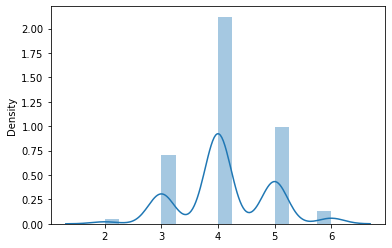

In [30]:
A_Tries_Test(words_historicals)

In [34]:
#All Words (8k)
Result3=Six_Tries_Test(words_refine)
print(Result3)

(8632, 0.9668458781362007, ['LOWES', 'HINGS', 'SHAHS', 'NOONS', 'GAGER', 'PANAX', 'HEWER', 'ZINES', 'VOLES', 'WAGGA', 'VAPES', 'KELLS', 'FOLLY', 'SANDS', 'MAXES', 'EGGER', 'PELES', 'HOWES', 'VEERS', 'WANGS', 'YUCKS', 'VANES', 'ZANJA', 'LOGES', 'TETES', 'WISES', 'JEERS', 'SQUIZ', 'SATES', 'DAGGA', 'FELLS', 'PROLL', 'DOWER', 'FRAYS', 'LOLLY', 'JELLS', 'PALLS', 'HAKES', 'DOZER', 'WEEKE', 'DOMES', 'BOOSE', 'PILIS', 'HAILS', 'VANDA', 'RAKER', 'SIMPS', 'SHADS', 'BEEPS', 'FAYER', 'JAPES', 'KRILL', 'MODER', 'DAFFS', 'HOODS', 'JUSTS', 'SANTS', 'BAKES', 'ALFAS', 'RIPER', 'GILLS', 'DOGIE', 'NONES', 'GAGES', 'HANTS', 'EALES', 'DAMES', 'VILLS', 'VIRES', 'TALLS', 'PROSS', 'SEXTS', 'TIGHT', 'POLKS', 'SAXES', 'HUGER', 'FADDY', 'LOPES', 'FUZES', 'TAWAS', 'KIGHT', 'PONTS', 'BREER', 'HADES', 'ZANZA', 'HIVES', 'LUGER', 'WADED', 'GALLS', 'VELLS', 'KINES', 'WAKED', 'BOWER', 'EMMER', 'HYLES', 'VEXES', 'POONS', 'ZINGS', 'SIKES', 'ZAPPY', 'POODS', 'WIPES', 'PREMS', 'JADES', 'BOTES', 'FAZES', 'VENDS', 'YANGS', 

# Initial Performance Inquiry

In [ ]:
print("Missed Words with TieBreak")
print(np.mean(Guesses))
sns.distplot(Guesses,bins=10)

In [315]:
Guesses=[]

for word in Missed:
    
    Sim=WordleSim(str(word))
    Solver=WordleSolver2()
    print('Word: '+word)
    gcount=0
    
    while(Sim.win==False):
        
        print()
        
        guess=Solver.generate_mixed_wp()
        
        
        Sim_Output=Sim.play(guess)
        Solver.update(Sim_Output[0])
        
        gcount+=1
        if(not Solver.notTieBreak):
            print('TieBreak Used')
            print()
        
        print()
        print(guess)
        
    
    Guesses.append(gcount)
    print('------------------')

Word: BOOBY


CARES


PONTY


DOWLY


BOBBY


BOOBY
------------------
Word: BOOZY


CARES


PONTY


DOWLY


BOBBY


BOOZY
------------------
Word: CRASS


CARES


CRABS


CRAGS


CRASS
------------------
Word: CRAZE


CARES


CRANE


CRAKE


CRATE


CRAVE


CRAZE
------------------
Word: FOYER


CARES


TONER


DOWER


ROGER


LOVER


POKER


HOMER


BOXER


FOYER
------------------
Word: HATCH


CARES


MATCH


BATCH


WATCH


PATCH


HATCH
------------------
Word: JAUNT


CARES


MANLY


TAUON


HAUNT


GAUNT


JAUNT
------------------
Word: LARVA


CARES


PARDY


MARON


GARTH


LARVA
------------------
Word: LIGHT


CARES


PONTY


BIGHT


MIGHT


LIGHT
------------------
Word: LIVER


CARES


TONER


FIVER


RIVER


LIVER
------------------
Word: MOIST


CARES


SOILY


ZOIST


MOIST
------------------
Word: PAPER


CARES


LAKER


GATER


PAPER
------------------
Word: POWER


CARES


TONER


DOWER


POWER
------------------
Word: SEVER


CARES


SIKER


SOBER


SUPER


SHEER



Missed Words without TieBreak


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

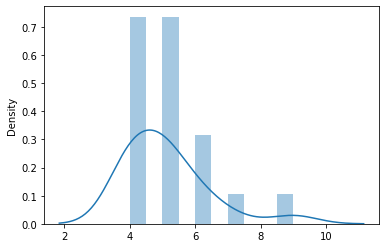

In [316]:
print("Missed Words without TieBreak")
sns.distplot(Guesses,bins=10)

In [318]:
print(np.mean(Guesses))

5.105263157894737


Avg Tries: 4.05868544600939


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


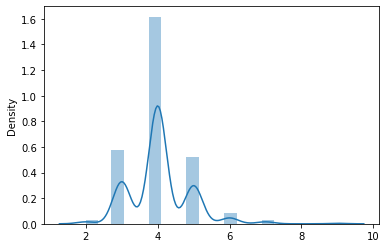

In [320]:
result2=Any_Tries_Test(words_historicals)

# Time Inquiry (What takes the longest in TieBreak?)

In [313]:
#Time Analysis

TestL=['EVADE', 'HATCH', 'SEVER']




Solver=exp_WordleSolver_time()
Sim=WordleSim('SEVER')
guesses=0
while not Sim.win and guesses<10:
    
    guesses+=1
    
    guess=Solver.generate_mixed_wp()
    State=Sim.play(guess)[0]
    Solver.update(State)
    
    print('Guess: '+guess)
    print()
    print('List Size: '+str(len(Solver.word_list)))


    
    
    
    

print()


Guess: CARES

List Size: 39
Guess: SIDER

List Size: 13
getRemLetters: 1.9311904907226562e-05
getWordFromLetters: 0.0030317306518554688
sortDict: 0.0007569789886474609
Guess: BUTOH

List Size: 5
getRemLetters: 8.106231689453125e-06
getWordFromLetters: 0.0011959075927734375
sortDict: 4.0531158447265625e-06
Guess: FAWNS

List Size: 2
getRemLetters: 3.814697265625e-06
getWordFromLetters: 0.0006110668182373047
sortDict: 3.0994415283203125e-06
Guess: SEVER

List Size: 1



# Solution: Efficient Structure for Storing Words

In [38]:
#Lets use a merge sort to sort words in the list

#MergeSort

def MergeSort(List):
    
   
    
    if len(List)==1:
        return List
    
    
    
    Left=List[0:len(List)//2]
    Right=List[len(List)//2:len(List)]

    return merge(MergeSort(Left),MergeSort(Right))
        

        
def merge(Lx,Ly):
    
    Ret=[]
    
    if len(Lx)>=len(Ly):
        L1=Lx
        L2=Ly
        
    else:
        L2=Lx
        L1=Ly
        
 

    L2_index=0
    L1_index=0
    
    while L1_index<len(L1):
        
        
        
        #While both lists are still going
        if(L2_index<len(L2)):
        
        
            if L1[L1_index]>L2[L2_index]:
                Ret.append(L2[L2_index])
                L2_index+=1

            else:
                Ret.append(L1[L1_index])
                L1_index+=1
                
        #Only big list
        else:
            Ret.extend(L1[L1_index:len(L1)])
            break
            
            
            
            
    '''
    print('This Merge')
    print(L1)
    print(L2)
    
    print(Ret)
    print()
    '''
    
    
    return Ret
        

In [315]:
#Approach 1:
# Encode and Decode Words

def Encode(word):
    
    intword=0
    Used={}
    for letter in word:
        
        L=2**(ord(letter)-ord('A'))
        
        if (L in Used)==False:
            
            Used[L]=1
            intword+=L
        
    
    
    return intword


In [180]:
def EncodeList(List):
    
    Dict={}
    
    for word in List:
        
        Val= Encode(word)
        
        if (Val in Dict)==False:
            
            Dict[Val]=[]
        
        
        Dict[Val].append(word)
        
            
            
    
    return Dict

In [218]:
import time

Master=EncodeList(words_refine)

In [193]:
def viableKeys(Dict,encry):
    
    retKeys=[]
    
    for key in Dict:
        
        if key & encry == encry:
            retKeys.append(key)
    
    return retKeys
            
        
        

In [245]:
def getWordsFromLetters(Letters,Dict):
    st = time.time()
    
    AZ=['A','B','C','D','E','F','G','H','I','J','K','L','M',
        'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    
    #Step 1: Encode Letters:
    
    Val=Encode(Letters)
    
    #Search for every word taking those values
    
    Keys=viableKeys(Dict,Val)
    
    Ret_Words=[]
    
    for k in Keys:
        Ret_Words.extend(Dict[k])
    
    et = time.time()
    
    return Ret_Words,et-st


In [246]:
# For comparison, using word list

def getWordsSlow(Letters,List):
    st = time.time()
    Word_Scores={}
    
    for word in List:
            score=0
            
            for L in Letters:
            
                if L in word:
                    
                    
                    score+=1
            

            if score>=2:
                Word_Scores[word]=score
                    
                
    Word_Scores=sortDict(Word_Scores)

    et = time.time()
   
    
    if(len(Word_Scores)>0):
        return list(Word_Scores.keys()),et-st
    else:
        return '',et-st
    

In [222]:
#Basic Test for time

#Encoded Method
x=getWordsFromLetters(['A','X'],Master)

print()

#Normal
y=getWordsSlow(['A','X'],words_refine)

0.0010340213775634766

0.0014867782592773438


In [262]:
#Proper test case for time

def Test():
    AZ=['A','B','C','D','E','F','G','H','I','J','K','L','M',
        'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    
    Time1=[]
    Time2=[]
    
    for i in range(0,100):
        Lets=[AZ[random.randrange(0,26)] for i in range(0,random.randrange(2,4))]

        Time1.append(getWordsFromLetters(Lets,Master)[1])
        Time2.append(getWordsSlow(Lets,words_refine)[1])
    
    
    T1=np.mean(Time1)
    T2=np.mean(Time2)
    
    return T2/T1
    


In [264]:
#Almost 10x difference in times

Hist=[Test() for i in range(0,10)]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

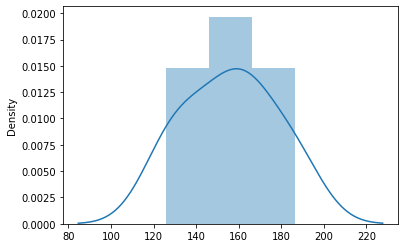

In [265]:
sns.distplot(Hist)

In [263]:
Test()

126.30446858213213